# Optiver Volatility EDA #

## Import Necessary Packages ##

In [2]:
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

In [3]:
# Change Working Directory

os.chdir(r'C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility')

# List All Book Folders ##

book_train_foldrs = os.listdir(r'Data\book_train.parquet')

## Get Data ##

### Get Trade Training Data

In [4]:
############################### Get Trade Training Data #######################################

os.chdir(r'C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility')

trade_train_foldrs = os.listdir(r'Data\trade_train.parquet')

# Initialize list of trade tables #

trade_train_lst = []

for fldr in trade_train_foldrs:

    os.chdir(os.path.join(r'C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility\Data\trade_train.parquet',fldr))
    fldr_file = os.listdir(os.getcwd())
    temp = pq.read_table(fldr_file, memory_map=True)
    temp_id = temp.append_column('stock_id', pa.array([str(fldr)] * len(temp), pa.string()))
    trade_train_lst.append(temp_id)

for tbl in range(0,len(trade_train_lst),1):
    trade_train_lst[tbl] = trade_train_lst[tbl].to_pandas()

trade_train = pd.concat(trade_train_lst, axis=0).reset_index(drop=True)

trade_train['stock_id'] = trade_train['stock_id'].str.replace('stock_id=','').astype('int32')

# get rid of list to save working memory #

del(trade_train_lst)

### Get Order Book Training Data ##

In [5]:
## Initialize List of Apache Tables ##

book_train_lst = []

for fldr in book_train_foldrs:

    os.chdir(os.path.join(r'C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility\Data\book_train.parquet',fldr))
    fldr_file = os.listdir(os.getcwd())
    temp = pq.read_table(fldr_file, memory_map=True)
    temp_id = temp.append_column('stock_id', pa.array([str(fldr)] * len(temp), pa.string()))
    book_train_lst.append(temp_id)

for tbl in range(0,len(book_train_lst),1):
    book_train_lst[tbl] = book_train_lst[tbl].to_pandas()

book_train = pd.concat(book_train_lst, axis=0).reset_index(drop=True)

book_train['stock_id'] = book_train['stock_id'].str.replace('stock_id=','').astype('int32')

# get rid of list to save working memory #

del(book_train_lst)

### Get Target Variables

In [10]:
os.chdir(r'C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility')

y_train = pd.read_csv(r"C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility\Data\train.csv")
y_test = pd.read_csv(r"C:\Users\Greg.Bone\Documents\GitHub\Optiver_Volatility\Data\test.csv")

book_train = pd.merge(book_train, y_train, how='left', on = ['time_id','stock_id'])
trade_train = pd.merge(trade_train, y_train, how='left', on = ['time_id','stock_id'])

trade_train = trade_train.rename({'price':'trade_price','size':'trade_size'})


## Feature Engineering

### Get Log Return and Realized Volatility

In [7]:
def log_return(prices):

    log_return = np.log(prices).diff()

    return log_return

def realized_volatility(log_return):

    return np.sqrt(np.sum(log_return**2))

### Weighted Average Price, Log Return, and Realized Volatility Calculations

In [14]:
book_train['wap1'] = (book_train.bid_price1*book_train.ask_size1+book_train.ask_price1*book_train.bid_size1)/(book_train.bid_size1+book_train.ask_size1)
book_train['wap2'] = (book_train.bid_price2*book_train.ask_size2+book_train.ask_price2*book_train.bid_size2)/(book_train.bid_size2+book_train.ask_size2)

book_train.sort_values(['stock_id','time_id','seconds_in_bucket'])

book_train['log_return'] = log_return(book_train['wap1'])

rvol = book_train.groupby(['stock_id','time_id'])['log_return'].agg(realized_volatility).reset_index()
rvol = rvol.rename(columns={'log_return':'realized_volatility'})

## Questions

### Are Some Stocks Inherently More Volatile?

In [19]:
# We can't plot every stock, so let's pick six random ones and visualize their volatility and returns

stocks = np.random.choice(rvol.stock_id.unique(), size=6)

In [20]:
stocks_graphs = stocks

In [21]:
sgraph = pd.pivot_table(rvol.loc[rvol['stock_id'].isin(stocks_graphs),:].reset_index(), index='time_id',columns='stock_id', values='realized_volatility')

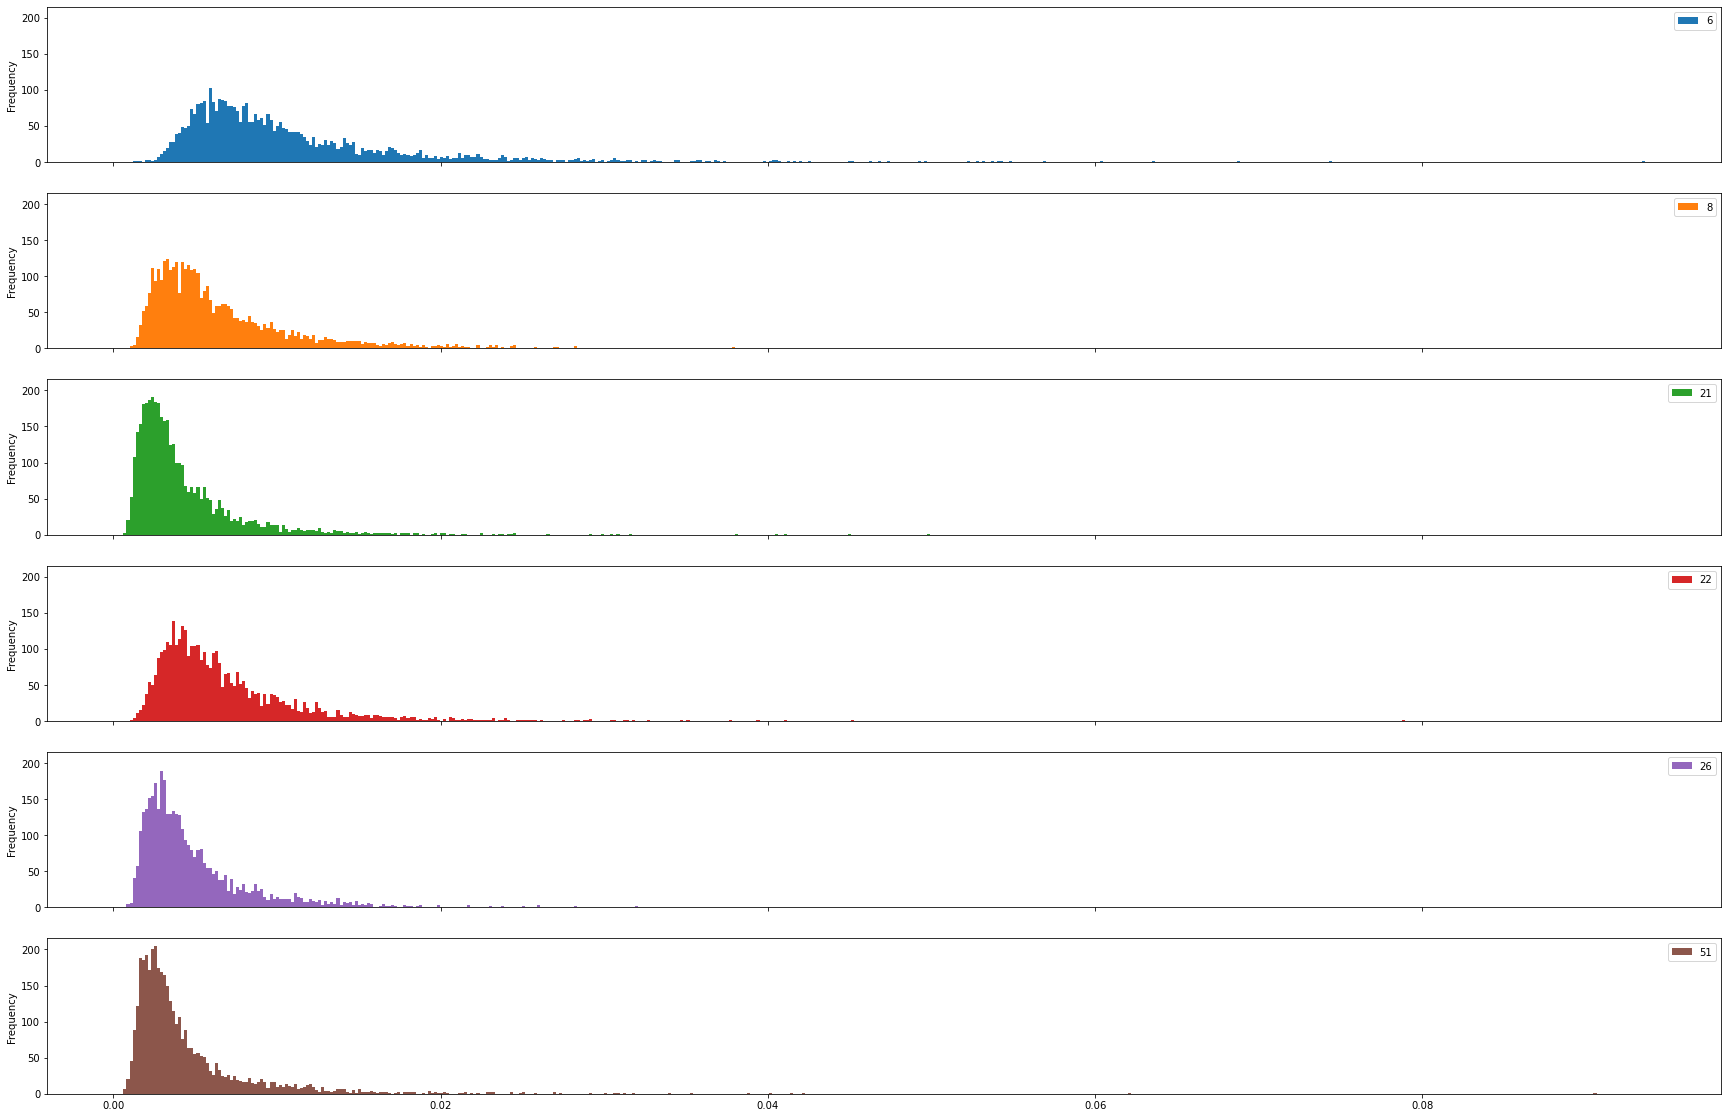

In [22]:
sgraph.plot(kind='hist', bins=500,subplots=True, sharex=True, sharey=True)
fig = plt.gcf()
fig.set_size_inches(30, 20)

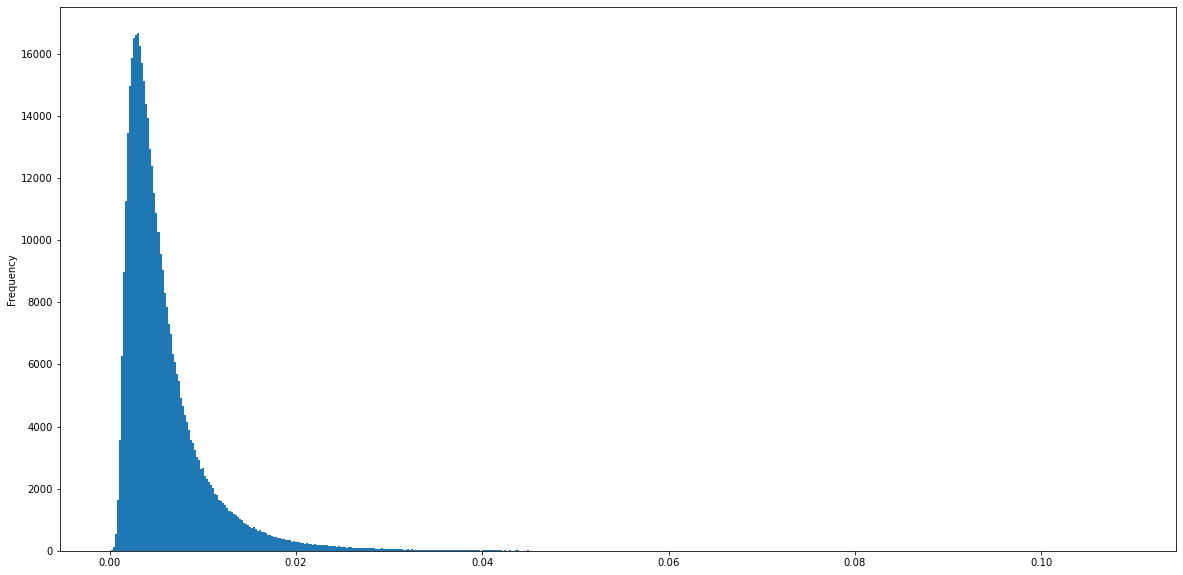

In [25]:
rvol['realized_volatility'].plot(kind='hist',bins=500)
fig = plt.gcf()
fig.set_size_inches(20, 10)

### Do Some Stocks have Different Order Size Distributions?

In [26]:
sizegraph = pd.pivot_table(trade_train.loc[trade_train['stock_id'].isin(stocks_graphs),:].reset_index(), index='time_id',columns='stock_id', values='size')

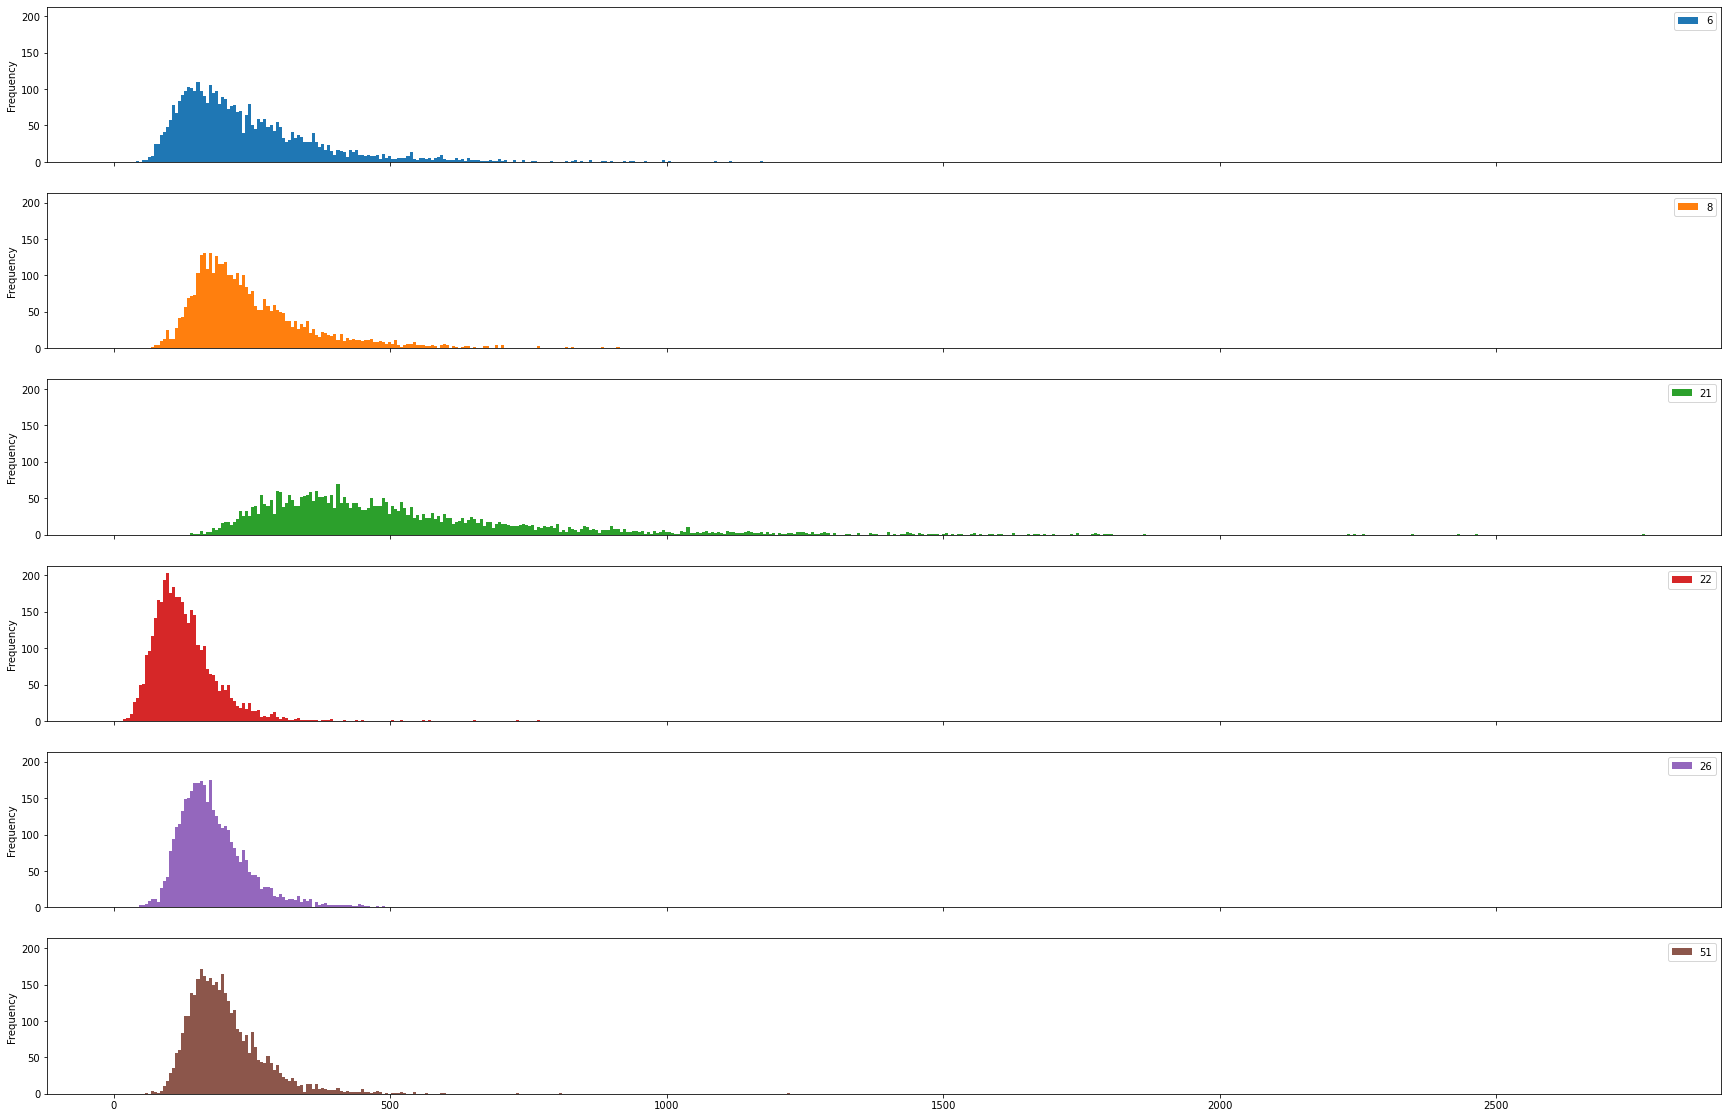

In [27]:
sizegraph.plot(kind='hist', bins=500,subplots=True, sharex=True, sharey=True)
fig = plt.gcf()
fig.set_size_inches(30, 20)

The distribution of each stock's order size varies much more than realized volatility. Let's do some feature engineering and see how those variables perform.